In [1]:
from __future__ import print_function
from datascience import *

import numpy as np
from scipy import stats, special
import pandas as pd
import matplotlib.pyplot as plt


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import itertools

import seaborn as sns

%matplotlib inline

In [2]:
POSSIBLE_VARIABLES = make_array("Size", "Shape", "Weight", "Height", "Width", "Density", "Length", "Time",
                               "Speed", "Acceleration", "Reflectivity", "Emissivity", "Strength", "Age",
                               "Bounce", "Price", "Rarity", "X", "Y", "Z", "Number", "Cost", "Absorptivity",
                                "Magnetism", "Conductance", "Impedance", "Resistance", "Volume", "Boiling", "Melting", 
                                "Freezing")

def generate_data(n, r, sample_size):
    np.random.seed(8)
    # build the table
    table = Table()
    variable_names = np.random.choice(POSSIBLE_VARIABLES, n, replace=False)
    for i in np.arange(n-1):
        mean = stats.norm.rvs(250, 300)
        std = abs(stats.norm.rvs(50, 20))
        values = stats.norm.rvs(mean, std, sample_size)
        table = table.with_column(variable_names.item(i), values)
    signal_column = np.random.choice(n-1)
    signal = table.column(signal_column)
    mean = stats.norm.rvs(250, 300)
    std = abs(stats.norm.rvs(50, 20))
    z = (signal - np.mean(signal)) / np.std(signal)
    z_rescaled = z * std + mean
    noise = stats.norm.rvs(mean, std, sample_size)
    signal_and_noise = r*z_rescaled + (1-abs(r))*noise
    table = table.with_column(variable_names.item(n-1), signal_and_noise)
    # print("Signal is " + str(variable_names.item(signal_column)))
    result_column = variable_names.item(n-1)
    # print("Result is " + str(result_column))
    return table.select(np.sort(table.labels)), make_array(variable_names.item(signal_column), variable_names.item(n-1))
    

def correlation(x, y):
    x_z = (x-np.mean(x))/np.std(x)
    y_z = (y-np.mean(y))/np.std(y)
    
    return np.mean(x_z*y_z)

def bootstrap_correlations(tbl, x_col, y_col):
    tbl_select = tbl.select(x_col, y_col)
    correlations = make_array()
    for i in np.arange(1000):
        resample = tbl_select.sample()
        corr = correlation(resample.column(0), resample.column(1))
        correlations = np.append(correlations, corr)
    return correlations

def p_value(tbl, x_col, y_col, p):
    correlations = bootstrap_correlations(tbl, x_col, y_col)
    upper = percentile((1-p/2) * 100, correlations)
    lower = percentile(p/2 * 100, correlations)
    if lower <= 0 and upper >= 0:
        return False
    else:
        return True

def calculate_stats(data, p=0.05):
    correlations = Table(make_array("Variable X", "Variable Y", "Corr", "Passes Hypothesis Test"))
    for i in np.arange(data.num_columns):
        for j in np.arange(data.num_columns):
            if j < i:
                corr = correlation(data.column(i), data.column(j))
                correlations = correlations.append(make_array(i, j, corr, p_value(data, i, j, p)))
    return correlations.sort("Passes Hypothesis Test", descending=True)

def perform_test(num_variables=7, p_value=0.05, true_corr=.5):
    print("Generating Data...")
    data, true_pair = generate_data(num_variables, true_corr)
    print("Calculating Correlations and Significance...")
    stats_table = calculate_stats(data, p_value)
    print("Bootstrapping Finished...")
    passed_tests = stats_table.where(3, 1)
    print(f"Out of {special.comb(num_variables, 2)} pairs of correlations, {passed_tests.num_rows} were significant")
    found = False
    for i in np.arange(passed_tests.num_rows):
        col_x = data.labels[int(passed_tests.column(0).item(i))]
        col_y = data.labels[int(passed_tests.column(1).item(i))]
        data.scatter(col_x, col_y)
        if np.all(np.sort(make_array(col_x, col_y)) == np.sort(true_pair)):
            found = True
    if found:
        print(f"The true signal pair {true_pair} was found!")
    else:
        print(f"The true signal pair {true_pair} was not found :(")
    
    num_found = passed_tests.num_rows - int(found)
    # This calculation is actually wrong! A binomial model is an underapproximation since correlations are not independent
    # print(f"With a P value of {p_value}, the probability that {num_found} or more correlations are inccorectely found to be significant \n under the null hypothesis is {1-stats.binom.cdf(num_found-1, stats_table.num_rows-1, p_value)}")
    
    
    
    

def perform_test(num_variables=7, p_value=0.05, true_corr=.5, sample_size_log = 2, out_found = False):
    print("Generating Data...")
    data, true_pair = generate_data(num_variables, true_corr, 10**sample_size_log)
    print("Calculating Correlations and Significance...")
    stats_table = calculate_stats(data, p_value)
    print("Bootstrapping Finished...")
    passed_tests = stats_table.where(3, 1)
    print(f"Out of {special.comb(num_variables, 2)} pairs of correlations, {passed_tests.num_rows} were significant")
    found = False
    all_pairs = []
    '''
    fig_x = 15
    fig_y = 15
    figsize = (fig_x, fig_y)
    if stats_table.num_rows % 3 == 0:
        fig, axes = plt.subplots(stats_table.num_rows//3, 3, figsize=figsize)
    else:
        fig, axes = plt.subplots(stats_table.num_rows//3 + 1, 3, figsize=figsize)
        for i in np.arange(stats_table.num_rows, (stats_table.num_rows //3 + 1)*3):
            axes[i//3, i%3].axis('off')
    fig.tight_layout(pad=3)
    
    
    
    
    for i in np.arange(stats_table.num_rows):
        col_x = data.labels[int(stats_table.column(0).item(i))]
        col_y = data.labels[int(stats_table.column(1).item(i))]
        all_pairs.append(np.sort(make_array(col_x, col_y)))
        
        axes[i//3, i%3].scatter(data.column(col_x), data.column(col_y))
        axes[i//3, i%3].set_xlabel(col_x)
        axes[i//3, i%3].set_ylabel(col_y)
    '''
    sns.pairplot(data.to_df())
    
    
    found = False
    for i in np.arange(passed_tests.num_rows):
        col_x = data.labels[int(passed_tests.column(0).item(i))]
        col_y = data.labels[int(passed_tests.column(1).item(i))]
        if np.all(np.sort(make_array(col_x, col_y)) == np.sort(true_pair)):
            found = True
    if out_found:
        if found:
            print(f"The true signal pair {true_pair} was significant!")
        else:
            print(f"The true signal pair {true_pair} was not significant! :(")
            
    def guesser(x, y):
        data.scatter(x, y)
        sig = False
        for i in np.arange(stats_table.num_rows):
            col_x = data.labels[int(stats_table.column(0).item(i))]
            col_y = data.labels[int(stats_table.column(1).item(i))]
            if np.all(np.sort(make_array(col_x, col_y)) == np.sort(make_array(x, y))):
                sig = True
        if sig:
            print("Result is Significant")
        else:
            print('Result is not Significant')
        if np.all(np.sort(make_array(x, y)) == np.sort(true_pair)):
            print("Correct Guess! This was the true association")
        else:
            print("Try Again :( This was not the true association")
    
    
    return lambda : interact(guesser, x= list(data.labels), y = list(data.labels))
    
    #num_found = passed_tests.num_rows - int(found)
    # This calculation is actually wrong! A binomial model is an underapproximation since correlations are not independent
    # print(f"With a P value of {p_value}, the probability that {num_found} or more correlations are inccorectely found to be significant \n under the null hypothesis is {1-stats.binom.cdf(num_found-1, stats_table.num_rows-1, p_value)}")
    
    
    
    

# START QUESTIONS

##  Key Terms / Review
Let's review some key terms first!

An association is a predictable relationship between two variables. A specific kind of association we will be looking at is a linear association, otherwise known as a correlation. A correlation means as one variable increases, the other variable either increases as well (positive correlation) or decreases (negative correlation).

Associations can be more or less meaningful. There are a number of ways to test how meaningful-- or significant-- a correlation is.

A p-value is the probability of seeing results like you got or more extreme, IF your hypothesis were false. So the smaller the p-value, the less likely your pattern is the result of chance, and the more likely it is to be a result of a true association. Scientists choose a cut-off of probability that they agree to consider "statistically significant," typically .05. This means that, on average, 5% of all findings that are "statistically significant at .05" are actually due to chance, and not a true association. The lower the p-value, the less likely it is the apparent association is due to chance, and the more likely it is to replicate.

Scientists typically set a rigid cutoff to determine when a correlation will be considered statistically significant or not significant-- this is called a p value cutoff or alpha. A p value cutoff tells us the probability that we will call a non significant correlation significant. For example, if we test 20 different correlations that are not significant, if we use the common p value cut off of 5%, we would expect one of them, on average to be classified as significant incorrectly (5% = 1 in 20). 


## Getting Started

Tam is running a simple study where she measures certain variables of a set of marbles, looking for associations among the variables. As her first experiment, she collects the following data. Run the code cell below to inspect the results of her study.

Tam knows that in each study, only two of the variables are actually correlated! For each study, the marble factory sends Tam a fresh batch of marbles. When ordering the marbles from the factory, Tam can control the true correlation in the associated variables and the number of marbles. All the other variables are generated randomly. 

The cell will tell you, 1: how many pairs of correlations were statistically significant, and 2: display graphs of the associations between all variables

Generating Data...
Calculating Correlations and Significance...
Bootstrapping Finished...
Out of 6.0 pairs of correlations, 0 were significant


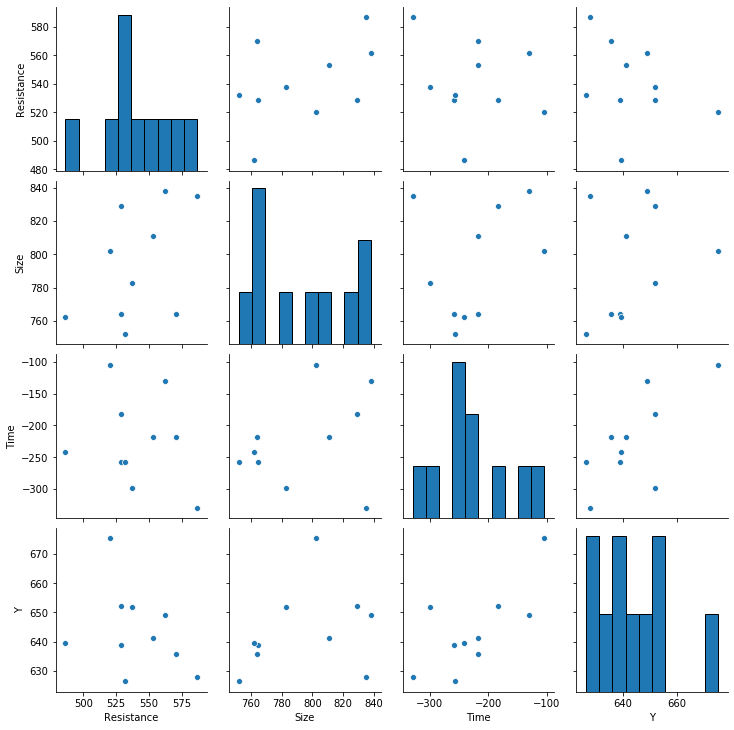

In [3]:
guesser = perform_test(num_variables=4, p_value=0.05, true_corr=0.45, sample_size_log=1);

**Question 1:** Looking at the graphs, can you tell which correlation is the true correlation? Why or why not?

You can't tell, the sample size is too small. Multiple graphs appear to show a correlation, but none reach statistical significance. The weaker the effect, the larger the sample size needed to reliably detect the effect.

**Question 2:** None of the correlations were statistically significant. Besides increasing the sample size, what else can Tam do to improve statistical significance?

Tam could raise the p value cutoff.

Tam chose to increase the sample size. Run the following cell to see the results of the experiment with the new sample size.

In [ ]:
guesser = perform_test(num_variables=4, p_value=0.05, true_corr=0.45, sample_size_log=2);

**Question 3:** With the new sample size, two results are significant. Interact with the cell below to identify your guess for pair of variables were actually correlated.

In [ ]:
guesser();

Unsure of her results, Tam observed more variables in her next experiment.

**Question 4:** As Tam observes the correlations among a larger set of variables, will the number of statisically significant results increase, decrease or stay the same, and why?

Increase. As the number of comparisons increases, the number of tests for significance increases. If we perform more tests, we will see more significant results even if they are not truly significant, because our p value can be interpreted as a false positive rate. Since the p value is the proportion of non significant results that we deem significant under the null hypothesis, if we increase the number of non significant results but keep the p value fixed, the number reported as significant will increase.

In [ ]:
guesser = perform_test(num_variables=8, p_value=0.05, true_corr=0.45, sample_size_log=2);

**Question 5:** Try and find the true correlation!

In [ ]:
guesser();

**Question 6:** How can Tam reduce the number of false positives while still investigating the same, larger, number of variables?

Tam can reduce the p value cutoff or alpha.

Run the next cell to perform a test with 10 variables.

In [ ]:
guesser = perform_test(num_variables=10, p_value=0.05, true_corr=0.75, sample_size_log=2);

**Question 7:** In the previous example you should be able to identify the true correlation more easily than before, although there are more comparisons. Why?

Because the correlation, the signal, is stronger, it's easier to identify it.

In [ ]:
guesser();

**Question 8:** How would you describe the signal and noise in this study?

One example of signal and noise is in the generation of the true correlation-- the signal is the original variable and the noise is the random noise added. Another example is the signal is the actual correlation and the noise is the non significant (random) correlations.

**Question 9:** In creating this module, Yanay tried to approximate the probability of a certain number of incorrect correlations in this experiment using a binomial model. Is this correct?

No, the binomial model assumes independence, but each of the ‘trials’ i.e. correlations are not independent. E.G. if x -> y and y -> z then x -> z.

**Question 10:** What is a real life example of an experiment like the one we simulate here, observing lots of variables and looking for associations??

When finding patterns in human variation, companies like 23andme look for associations in data with a huge number of variables (humans and our genomes are very diverse!) To counter false positives, they use a very small p value, and have a very large sample size.

**Question 11:** Tam originally tested her main hypothesis, which was about a specific correlation between two variables. Why is there a lower chance of getting a false positive when testing one specific hypothesis, than when looking at a whole lot of possible correlations?

When testing one hypothesis, the likliehood of a false positive is equivalent to the p value. When testing multiple hypotheses, the likliehood of getting at least one false positive includes getting a false positive in any of the tests. This is equivalent to flipping a coin many times-- if you flip a coin once, the chance of at least one heads is lower than the chance of at least one heads in many flips.

**Question 12:** The factory was contacted by a few other data scientists who performed similar studies to Tam's. How would this affect the number of false positives? How does this relate to public data sets analyzed by many research groups, as is very common in data science?

If many people run experiments on the data set, the overall number of tests performed increases, although they might not be aware of it. If all these tests are performed with an unadjusted p value, the number of false positives will increase. This is the same as many different people running analyses on public data sets.